In [0]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = np.expand_dims(train_images, 3)
test_images = np.expand_dims(test_images, 3)

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
sss = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15)

train_index, valid_index = next(sss.split(train_images, train_labels))

x_valid, y_valid = train_images[valid_index], train_labels[valid_index]
train_images, train_labels = train_images[train_index], train_labels[train_index]

In [0]:
model.add(tf.keras.layers.BatchNormalization(input_shape=train_images.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(3,3)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization(input_shape=train_images.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization(input_shape=train_images.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.40.147.42:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17362590297417055769)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14313744146542037570)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7752905181711505116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6789268817312198019)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16413383183326732077)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
%%time
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, train_images.shape[0] - batch_size)
    yield train_images[offset:offset+batch_size], train_labels[offset:offset + batch_size]
    

history = tpu_model.fit_generator(
    train_gen(512),
    epochs=30,
    steps_per_epoch=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_260'), TensorSpec(shape=(64, 28, 28, 1), dtype=tf.float32, name='batch_normalization_40_input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='activation_27_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_40_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 18.354536056518555 secs
INFO:tensorflow:Setting weights on TPU model.
 99/100 [============================>.] - ETA: 0s - loss: 0.7383 - sparse_categorical_accuracy: 0.7482INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_270'), TensorSpec(shape=(64, 28, 28, 1), dtype=tf.float32, name='batch_normalization_40_input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='activation_27_target_10

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_sparse_categorical_accuracy', 'loss', 'sparse_categorical_accuracy'])


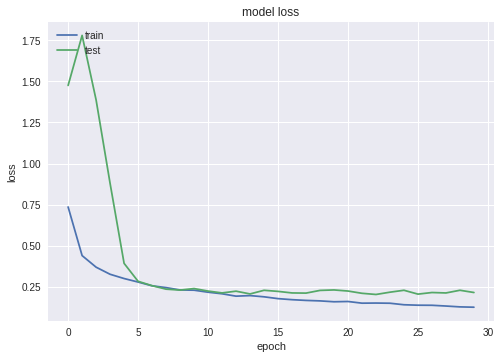

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model = tpu_model.sync_to_cpu()

score = model.evaluate(test_images, test_labels, verbose=0)

print('Test accuracy:', score[1])

INFO:tensorflow:Copying TPU weights to the CPU
Test accuracy: 0.9171
